In [2]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [9]:
pickle_file = 'brData10ClassSimple.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 28, 28) (100000,)
Test set (1000, 28, 28) (1000,)


In [3]:
image_size = 28
num_labels = 256
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

print ()

Training set (2560000, 28, 28, 1) (2560000, 256)
Test set (25600, 28, 28, 1) (25600, 256)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
batch_size = 100
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 25601

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 245.883667
Minibatch accuracy: 1.0%
Minibatch loss at step 50: 5.546196
Minibatch accuracy: 1.0%
Minibatch loss at step 100: 5.545593
Minibatch accuracy: 0.0%
Minibatch loss at step 150: 5.546764
Minibatch accuracy: 1.0%
Minibatch loss at step 200: 5.544579
Minibatch accuracy: 0.0%
Minibatch loss at step 250: 5.544536
Minibatch accuracy: 0.0%
Minibatch loss at step 300: 5.545156
Minibatch accuracy: 0.0%
Minibatch loss at step 350: 5.545358
Minibatch accuracy: 0.0%
Minibatch loss at step 400: 5.544584
Minibatch accuracy: 0.0%
Minibatch loss at step 450: 5.544004
Minibatch accuracy: 0.0%
Minibatch loss at step 500: 5.544646
Minibatch accuracy: 2.0%
Minibatch loss at step 550: 5.543982
Minibatch accuracy: 0.0%
Minibatch loss at step 600: 5.543113
Minibatch accuracy: 1.0%
Minibatch loss at step 650: 5.545492
Minibatch accuracy: 0.0%
Minibatch loss at step 700: 5.545101
Minibatch accuracy: 0.0%
Minibatch loss at step 750: 5.545870
Minibatch accuracy: 1.

2242401
153


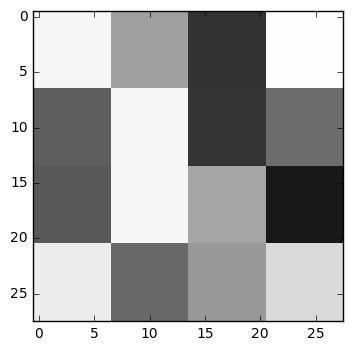

IndexError: index 2242401 is out of bounds for axis 0 with size 25600

In [7]:
#test the data
import random
import matplotlib.pyplot as plt
rand_image = random.randint(0, 2560000)
print (rand_image)
plt.imshow(train_dataset[rand_image], cmap='gray', interpolation='nearest', vmin=0, vmax=255)
print (train_labels[rand_image])
plt.show()
np.mean(test_dataset[rand_image])